# Year Prediction for Songs

This is the Python2 notebook for CS218 class project. We will complete it in several pieces.

This Jupyter notebook will go through the reproduction of ISMIR'11 paper. It has four methods:

- Constant Prediction
- 1 Nearest Neighbor
- 50 Nearest Neighbor
- Vowpal Wabbit

But we will start with loading the data.

# (0) Loading the data

Please run ```download.sh``` in the folder to download ```YearPredictionMSD.txt``` data file.

Here, we are loading the data file, dividing test-training parts, mapping years from 1922-2011 to 0-1.

In [1]:
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Open the file
df=pd.read_csv('YearPredictionMSD.txt', sep=',',header=None)

#Divide into training-test
trn = df.values[:463715,:]
tst = df.values[463715:,:]

#Functions to map 1922-2011 <-> 0-1
def ToZeroOne(x):
    return (x-1922)/89
def FromZeroOne(x):
    return x*89+1922

#Get training years (both actual years and mapped to 0-1) and features.
trn_ftr     = trn[:,1:]
tst_ftr     = tst[:,1:]
trn_yrs_int = trn[:,0].astype(int)
tst_yrs_int = tst[:,0].astype(int)
trn_yrs     = map(ToZeroOne,trn_yrs_int.astype(float))
tst_yrs     = map(ToZeroOne,tst_yrs_int.astype(float))

#Use numpy for speed
trn_ftr     = np.array(trn_ftr)
tst_ftr     = np.array(tst_ftr)
trn_yrs_int = np.array(trn_yrs_int)
tst_yrs_int = np.array(tst_yrs_int)
trn_yrs     = np.array(trn_yrs)
tst_yrs     = np.array(tst_yrs)

Now we have read our data, divided it into *training* and *test*. x_yrs will have actual years, whereas x_ftr will have 90 features. 

Let's take a look at frequencies of years in training data.

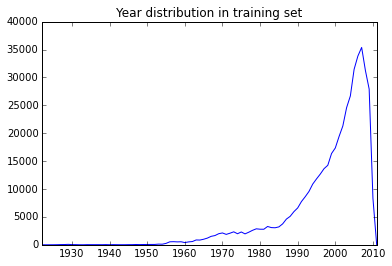

In [2]:
counts = np.bincount(trn_yrs_int)
counts = counts[-(2011-1922+1):]
plt.plot(xrange(1922,2011+1),counts) #use range for python3
plt.xlim([1922,2011])
plt.title("Year distribution in training set")
plt.show()

Seems like we have a peak through the end, the average will probably be around that part as well. Let's actually calculate it and see which year it corresponds to.

# (1) Constant Prediction

Here, our "model" will just guess the song is from the "average" year.

In [3]:
guess = np.average(trn_yrs)

FromZeroOne(guess)

1998.3860949077559

It's around the year 1998.4. Let's see how much error we get for guessing the average.

In [10]:
print "Method 1: Constant Prediction\n"

error = 0
sqerr = 0

#Calculate the error
for i in xrange(0,len(tst_yrs)):
    difference = guess-tst_yrs[i]
    
    error += abs(difference)
    sqerr += (difference)**2

#Average the error
error /= len(tst_yrs)
sqerr /= len(tst_yrs)

#Since they reported sqrt of sqerr, we followed them:
sqerr = math.sqrt(sqerr)
    
#"Diff"
print "Error: ",error

#Squared error
print "SqErr: ",sqerr

Method 1: Constant Prediction

Error:  0.0911580886729
SqErr:  0.121937796687


This is already interesting. Their diff was 8.13, while we had 9.12. Their sq.diff was 10.80, we had 12.19. It might be their update to the data they made after writing the paper. We can also say accuracy is zero, because all guesses were "1998.4", whereas our data was integers only. Let's move to the next method.

# (2) 1-Nearest Neighbor and (3) 10-Nearest Neighbor

In this part, we will calculate our error with 1-NN and 10-NN. For NN testing, we will follow the tutorial given [here](http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/).

In [5]:
#Adapted from http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


#Calculate Euclidean distance between two 90D vectors
#Return "k" closest neighbors of testInstance in training set
def getNeighbors(testInstance, k):
    distances   = np.sum((testInstance-trn_ftr[:])**2,axis=1)
    dist_tuples = []
    for x in range(len(trn_ftr)):
        dist_tuples.append((distances[x],trn_yrs[x])) #distance, year
    dist_tuples.sort(key=operator.itemgetter(0))
    neighbors = []
    for x in range(k):
        neighbors.append(dist_tuples[x][1])
    return neighbors

#Majority vote
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
	# use classVotes.items() in python3
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

In [ ]:
print "Method 2-3: 1NN-10NN\n"

one_error = 0
one_sqerr = 0
one_corrn = 0

ten_error = 0
ten_sqerr = 0
ten_corrn = 0

#Calculate the error
for i in xrange(0,len(tst_yrs)):
    ten_neighbors = getNeighbors(tst_ftr[i],k=10)
    one_neighbors = ten_neighbors[0]
    ten_guess = getResponse(ten_neighbors)
    one_guess = one_neighbors

    one_difference = one_guess-tst_yrs[i]
    ten_difference = ten_guess-tst_yrs[i]
    
    one_error += abs(one_difference)
    one_sqerr += (one_difference)**2
    ten_error += abs(ten_difference)
    ten_sqerr += (ten_difference)**2

    if (one_error==0):
        one_corrn+=1
    if (ten_error==0):
        ten_corrn+=1

    #print i,"1NN",FromZeroOne(one_guess).astype(int),"10NN",FromZeroOne(ten_guess).astype(int),"truth",FromZeroOne(tst_yrs[i]).astype(int)
    

#Average the error
one_error /= len(tst_yrs)
one_sqerr /= len(tst_yrs)
one_corrn /= len(tst_yrs)
ten_error /= len(tst_yrs)
ten_sqerr /= len(tst_yrs)
ten_corrn /= len(tst_yrs)

#Since they reported sqrt of sqerr, we followed them:
one_sqerr = math.sqrt(one_sqerr)
ten_sqerr = math.sqrt(ten_sqerr)
    
#"Diff"
print "1NN Error: ",one_error
print "KNN Error: ",ten_error

#Squared error
print "1NN SqErr: ",one_sqerr
print "KNN SqErr: ",ten_sqerr

#Correct guesses (percent)
print "1NN Correct: ",one_corrn
print "KNN Correct: ",ten_corrn

We run this part in a faster cloud machine, after dividing the task into 4 pieces. Still, it took very long to reach at results. 

1NN Error:  0.110083415487

KNN Error:  0.0914279869512

1NN SqErr:  0.157869954077

KNN SqErr:  0.139451772844

# (4) Vowpal Wabbit